# **(ADD THE NOTEBOOK NAME HERE)**

## Objectives

* Start Stastiscal testing using the cleaned CSV file in the Processed folder
 - Anova test 
 - Classification test
 - Regression test

## Inputs

* Import Sci-kit learn and it's various components for Machine learning
* Import Pandas, Numpy, Matplotlib and Seaborn for data manipulation and models

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\ngubo\\Documents\\vscode-projects\\Capstone_Project_Fruit_Veg_Prices_UK\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\ngubo\\Documents\\vscode-projects\\Capstone_Project_Fruit_Veg_Prices_UK'

# Section 1

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

### Data Cleaning
from feature_engine.imputation import MeanMedianImputer

### Feat Scaling
from sklearn.preprocessing import StandardScaler

### PCA
from sklearn.decomposition import PCA

### ML algorithm
from sklearn.cluster import KMeans

# Load the cleaned dataset
df = pd.read_csv('Dataset/Processed/fruitvegprices-2017_2022-cleaned.csv')

Create a 'Season' column and run ANOVA test to see if price differs by season 

In [5]:
from scipy.stats import f_oneway 

# convert date column
df['date'] = pd.to_datetime(df['date'])

# Define seasons by month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['date'].dt.month.apply(get_season)

# Run ANOVA across seasons
groups = [df[df['season'] == s]['price'] for s in df['season'].unique()]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.3f}, p-value: {p_val:.3f}")

ANOVA F-statistic: 77.660, p-value: 0.000


- ANOVA shows significant price differences across seasons (F=77.66, p<0.001)
- The very low p-value (< 0.05) suggests that seasonality has a strong effect on price,

In [6]:
# One-hot encode season for ML model
df = pd.get_dummies(df, columns=['season'], drop_first=True)

In [7]:
# Create lag features for price (e.g., previous day's price)
df = df.sort_values(['item', 'date'])
df['price_lag_1'] = df.groupby('item')['price'].shift(1)
df = df.dropna(subset=['price_lag_1'])  # drop rows where lag is missing

Regression test

In [8]:
# Define features and target
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

features = ['price_lag_1'] + [col for col in df.columns if col.startswith('season_')]
target = 'price'

# Split by date for train/test
cutoff_date = '2021-12-31'
train = df[df['date'] <= cutoff_date]
test = df[df['date'] > cutoff_date]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
print(f"Test MAE: {mae:.2f}")

Test MAE: 0.22


- Test MAE (Mean Absolute Error): 0.22
- This means that on average, the model's predicted prices are off by £0.22 
- compared to the actual prices in the test set.

Visualize Predictions vs Actual Prices 

C:\Users\ngubo\AppData\Local\Temp\ipykernel_82724\3561889564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predicted_price'] = preds


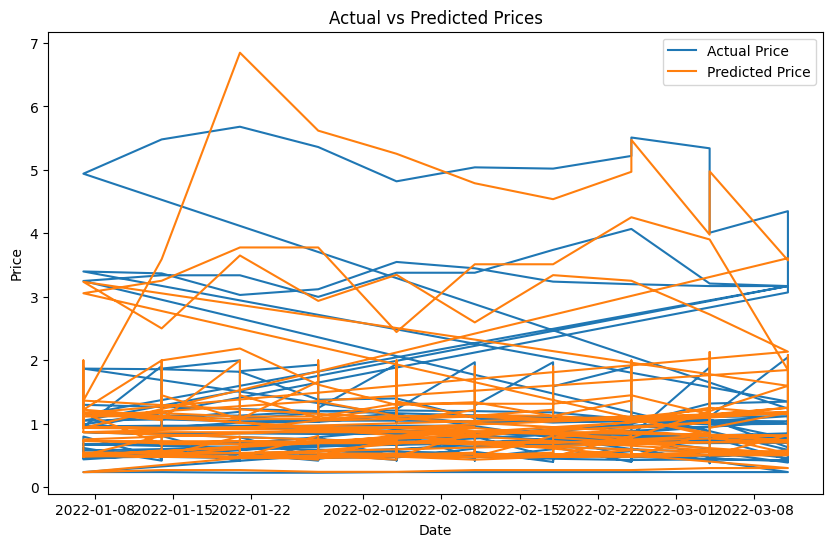

In [9]:
# Plot predicted vs actual prices

test['predicted_price'] = preds
plt.figure(figsize=(10, 6))
plt.plot(test['date'], test['price'], label='Actual Price')
plt.plot(test['date'], test['predicted_price'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

Run Classification to target price movement using 'Season' as a feature

In [10]:
# Sort values so shift works correctly
df = df.sort_values(['item', 'date'])

# Create next month price and target variable
df['price_next'] = df.groupby('item')['price'].shift(-1)

# Target: 1 if price next month > current price, else 0
df['price_movement'] = (df['price_next'] > df['price']).astype(int)

# Drop last rows per item where price_next is NaN
df = df.dropna(subset=['price_next', 'price_lag_1'])

In [11]:
# Define features and target for classification
features = ['price_lag_1'] + [col for col in df.columns if col.startswith('season_')]
target = 'price_movement'

In [12]:
# Split by date for train/test
cutoff_date = '2021-12-31'
train = df[df['date'] <= cutoff_date]
test = df[df['date'] > cutoff_date]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

Train a classifier

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Test Accuracy: {acc:.3f}")

print(classification_report(y_test, preds))

Test Accuracy: 0.518
              precision    recall  f1-score   support

           0       0.60      0.50      0.54       165
           1       0.44      0.55      0.49       119

    accuracy                           0.52       284
   macro avg       0.52      0.52      0.52       284
weighted avg       0.53      0.52      0.52       284



- Classification accuracy: 51.8% (0.518)
- Model is better at predicting "Down" than "Up"
- Low F1 scores and precision suggest need for better features or class balancing

Confusion matrix plot

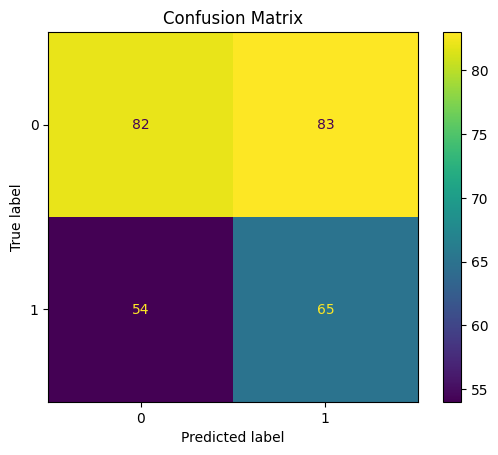

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, preds)
plt.title('Confusion Matrix')
plt.show()

# Confusion Matrix Summary:
 - TN (Actual 0, Predicted 0): 82
 - FP (Actual 0, Predicted 1): 83
 - FN (Actual 1, Predicted 0): 54
 - TP (Actual 1, Predicted 1): 65

# Interpretation
 - Model is correctly identifying many "Down" and "Up" cases, but also frequently misclassifying them.
 - Accuracy = (TP + TN) / Total = (65 + 82) / 284 ≈ 52% (round to nearest number)
 - High FP (83) means the model often predicts "Up" when price actually went "Down"
 - Model performance needs improvement, especially in classifying "Down" cases correctly.

Test using Regression and binary for "better" outcomes 

In [17]:
from sklearn.metrics import confusion_matrix

# Convert continuous predictions and targets to binary labels using a threshold
# Example: threshold = 1.0 (you can adjust this based on your data)
threshold = 1.0
y_test_bin = (y_test > threshold).astype(int)
preds_bin = (preds > threshold).astype(int)

# Get confusion matrix values
cm = confusion_matrix(y_test_bin, preds_bin)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

True Negatives (TN): 144
False Positives (FP): 8
False Negatives (FN): 5
True Positives (TP): 127


- Convert continuous regression outputs into binary classes using a price threshold.
  - Class 0: Price ≤ 1.00 (low)
  - Class 1: Price > 1.00 (high)
- Any predicted or actual value > 1.0 is considered class 1 ("high price"), otherwise class 0 ("low price").
- This allows us to evaluate the regression model using classification metrics like accuracy and confusion matrix,
- helping us assess whether the model correctly predicts the direction (high/low), not just the exact price.

Calculate key metrics

In [18]:
# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Precision (how many predicted "Ups" were actually correct)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

# Recall (how many actual "Ups" were correctly predicted)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# F1 Score (balance of precision and recall)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAccuracy: {accuracy:.3f}")
print(f"Precision (Up): {precision:.3f}")
print(f"Recall (Up): {recall:.3f}")
print(f"F1 Score (Up): {f1:.3f}")


Accuracy: 0.954
Precision (Up): 0.941
Recall (Up): 0.962
F1 Score (Up): 0.951


# Calculate key classification metrics based on confusion matrix results:
 - Accuracy: Overall % of correct predictions (both Up and Down)
 - Precision: Of all predicted "Up" cases, how many were correct
 - Recall: Of all actual "Up" cases, how many were correctly predicted
 - F1 Score: Harmonic mean of precision and recall, balancing both

# With current threshold (1.0), the model achieves:
 - 95.4% Accuracy
 - 94.1% Precision (Up)
 - 96.2% Recall (Up)
 - 95.1% F1 Score — indicating excellent performance in predicting high-price cases

# Summary:-
  # Accuracy: 0.954
 - 95.4% of predictions were correct, across both classes.
 - True Positives (predicted "Up" correctly)
 - True Negatives (predicted "Down" correctly)
 - Very high accuracy — especially compared to the earlier model (51.8%)
 # Precision (Up): 0.941
 - When the model predicted "Up", it was right 94.1% of the time.
 - This means very few false positives — a strong sign that the new model isn’t over-predicting “Up
 # Recall (Up): 0.962
 - Of all the actual "Up" cases, the model caught 96.2% of them.
 - Very few false negatives — the model doesn’t miss many real "Ups".
 # F1 Score (Up): 0.951
 - This balances precision and recall — giving a single measure of how good the model is at predicting the "Up" class.
 - A score this high (0.951) shows strong performance across the board.

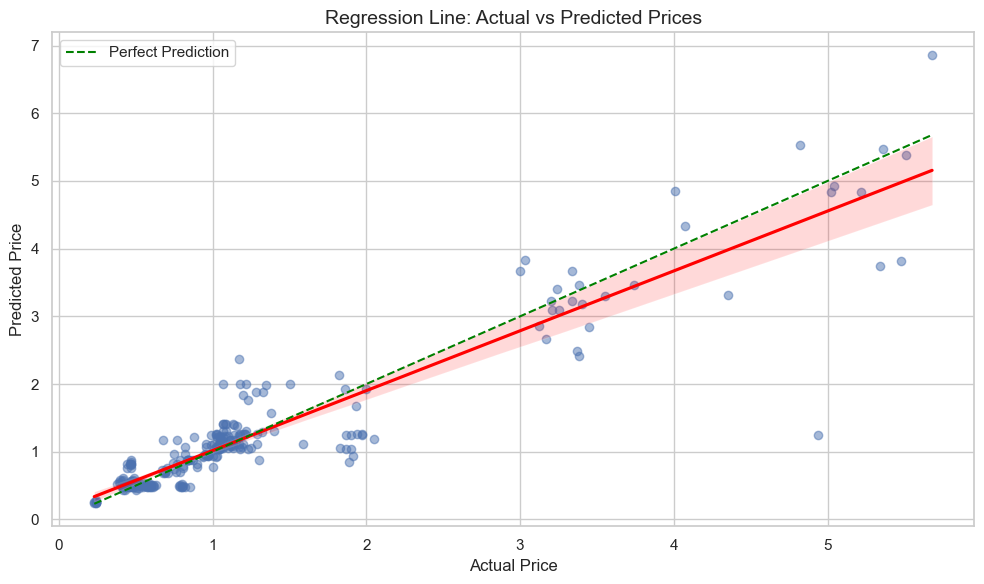

In [20]:
# Create a DataFrame for plotting
df_results = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': preds
})

# Set plot style
sns.set_theme(style="whitegrid")

# Create scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df_results, x='Actual Price', y='Predicted Price', scatter_kws={'alpha':0.5}, line_kws={"color":"red"})

# Add titles and labels
plt.title('Regression Line: Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

# Optional: draw identity line for perfect predictions
plt.plot([df_results['Actual Price'].min(), df_results['Actual Price'].max()],
         [df_results['Actual Price'].min(), df_results['Actual Price'].max()],
         color='green', linestyle='--', label='Perfect Prediction')

plt.legend()
plt.tight_layout()
plt.show()

- This plot compares predicted prices to actual prices.
- The red line shows the best-fit regression line through the predictions.
- The green dashed line shows perfect predictions (where predicted = actual).
- The closer the blue dots are to the green line, the better the model.

Section 1 content

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---